# Automatic grading of student responses in natural language

## Introduction

Authors:
- SAGDULLIN Damir
- LAIOLO Léo
- DEGIOVANNI Quentin
- LECAM Léonie
- COUCHOUD Matteo

### Description

This project involves using LLM (Large Language Model) for the automatic grading of student responses in natural language.


### Usage

This project is split in 3 parts:
1. [Environment](#scrollTo=Environment)
2. [LLM](#scrollTo=LLM)
3. [Analysis](#scrollTo=Analysis)

Only the 2 first one contains executable code.

To run the project:
1. Connect to a GPU session.
2. Execute the Environment section
3. Authorize this colab to access to your Google drive.
4. Run only **ONE** LLM subsection ([Gemini](#scrollTo=Gemini), [Gemma](#scrollTo=Gemma) or [Fine tuned Gemma](#scrollTo=wa_SahFZO9eV&line=1&uniqifier=1))
5. Wait until the code execution is done.

This project is composed of 3 LLM. **Only one per session can be setup.** If you want to use Gemini then Gemma, you need to restart the session. After each session restart, you need to re-run the code above the [LLM](#scrollTo=LLM) to import the dataset. Using more than one LLM will crash the RAM.

> To easily run a section code, you can collapse it then press the `Execute` ▶ button.

1. #### Gemini

To use Gemini, you must get a Google API key. To have one, you might have to use VPN in one of the countries from https://ai.google.dev/available_regions (USA seems to be a bit quicker than others). Once you have an API key, save it as a Google Colab secret named `GOOGLE_API_KEY` . Once it is done, you should be able to execute the [Gemini](#scrollTo=Gemini) section.


> ⚠️ Don't interrupt execution while Gemini API is being requested. Otherwise you'll have to restart session.

> See [Gemini documentation](https://ai.google.dev/tutorials/python_quickstart) for further information.


2. #### Gemma

To use Gemma, you must use your Kaggle (or create one) and provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, go to the [Account](https://www.kaggle.com/settings) tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.

In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

Once it is done, you should be able to execute the [Gemma](#scrollTo=Gemma) section.


3. #### Fine tuned Gemma

To use fine tined Gemma, you first ensure that you can run correctly the [Gemma](#scrollTo=Gemma) section. Restart the session. Now you can run the [Fine tuned Gemma](#scrollTo=wa_SahFZO9eV&line=1&uniqifier=1) section.


### Contact

For any question or difficulties, you can send an email to any administrator of this Google Colab.

## Environment

### Imports

Import needed python libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
!pip install json-repair
import json_repair

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import os
import datetime

from rich.progress import Progress, BarColumn, TextColumn, TaskProgressColumn, TimeRemainingColumn, TimeElapsedColumn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Execution mode

In [ ]:
# @markdown This jupyter notebook can either be run on Google colab or on a local machine.

# @markdown Please select your computation mode:
computation_mode = "Google Colab" # @param ["Google Colab", "Local"]

if computation_mode == "Google Colab":
    from google.colab import drive
    print("Connecting to Google Drive...")


    # Drive connection
    drive.mount('/content/drive')

    # Path when the files are in a shared drive
    path = '"/content/drive/Shareddrives/ING3 IA & applications 2/"'

    # Move in directories
    %cd $path

else:
    path = './'
    print("Executing with local datas")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/ING3 IA & applications 2


### Dataset

The dataset used is the one provided with the project specifications. Dataset columns are detailed below.

- **question**: The question that was asked.
- **student_answer**: The answer provided by the student.
- **grades_round**: The grade assigned to the student's answer.
- **student_modified**: The student's answer after some preprocessing like lowercasing, removing punctuation, etc.
- **ref_answer**: A reference answer for the question.
- **qn_modified**: The question after some preprocessing.
- **ref_modified**: The reference answer after some preprocessing.
- **student_demoted**: The student's answer after some further preprocessing, possibly removing less important words.
- **ref_demoted**: The reference answer after some further preprocessing.
- **length_ratio**: The ratio of the length of the student's answer to the length of the reference answer.
- **embed_stud, embed_ref_demoted, embed_stud_demoted**: These columns likely contain embeddings (numerical representations) of the student's answer, the demoted reference answer, and the demoted student's answer, respectively.
- **aligned, aligned_demoted**: These columns likely contain information about which words in the student's answer and the reference answer are aligned (i.e., match or are similar).
- **cos_similarity, cos_similarity_demo**: These columns likely contain the cosine similarity (a measure of similarity between two vectors) between the embeddings of the student's answer and the reference answer, and between the demoted versions of these, respectively.
- **aligned_score, aligned_score_demo**: These columns likely contain scores based on how well the student's answer aligns with the reference answer, for both the original and demoted versions.
- **question_id**: An identifier for the question.

- **feedback**: feedback generated by Gemini Pro (cf `Construct feedback column` section)

In [ ]:
# @markdown Row examples from the dataset:
df = pd.read_csv("Dataset/asag_dataset.csv", index_col=0)
df.head()

,question,student_answer,grades_round,student_modified,ref_answer,qn_modified,ref_modified,student_demoted,ref_demoted,length_ratio,...,embed_ref_demoted,embed_stud_demoted,aligned,aligned_demoted,cos_similarity,cos_similarity_demo,aligned_score,aligned_score_demo,question_id,feedback
0,"Give a definition for the term ""artificial ne...",An artificial neural network is a massively pa...,2,artificial neural network massively parallel d...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,massively parallel distributed processor simpl...,massively parallel distributed processor made ...,0.251889,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 2.0412598e+00 4.9321938e-01 1.0058594e-01...,"[['neural', 'neural'], ['network', 'network'],...","[['simple', 'simple'], ['processing', 'process...",0.947867,0.933466,0.969697,0.950888,1,The student's answer is partially correct but ...
1,"Give a definition for the term ""artificial ne...",Artificial neural network consists of: . Large...,2,artificial neural network consists largely par...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,consists largely parallel distributed processo...,massively parallel distributed processor made ...,0.232759,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 1.19566895 0.7539518 0.13561035 1.22295...,"[['knowledge', 'knowledge'], ['parallel', 'par...","[['knowledge', 'knowledge'], ['knowledge', 'kn...",0.964398,0.951182,0.883259,0.818713,1,The student's answer is precise and covers the...
2,"Give a definition for the term ""artificial ne...",An artificial neural network is a massive dist...,1,artificial neural network massive distributed ...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,massive distributed processor consists several...,massively parallel distributed processor made ...,0.102828,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 3.84277344e-01 -4.89446640e-01 1.72241211e...,"[['knowledge', 'knowledge'], ['neural', 'neura...","[['knowledge', 'knowledge'], ['distributed', '...",0.854767,0.775333,0.498039,0.465632,1,The answer given by the student is off-topic a...
3,"Give a definition for the term ""artificial ne...",An ANN is a layered graphical model containing...,2,ann layered graphical model containing neuron ...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,ann layered graphical model containing neuron ...,massively parallel distributed processor made ...,0.327616,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 1.97546387e+00 1.12967682e+00 -6.56402588e...,"[['resemble', 'resembling'], ['neural', 'neuro...","[['environment', 'environment'], ['learning', ...",0.788166,0.735229,0.322950,0.220386,1,The student's answer provides a reasonable def...
4,"Give a definition for the term ""artificial ne...",Artificial Neural Networks are large parallel ...,2,artificial neural network large parallel proce...,A neural network is a massively parallel distr...,give definition term artificial neural network...,neural network massively parallel distributed ...,large parallel processing unit natural ability...,massively parallel distributed processor made ...,0.286963,...,[[ 1.6300049e+00 1.5985355e+00 -1.2829590e-01...,[[ 0.68797852 0.72406174 -0.85735535 1.14616...,"[['knowledge', 'knowledge'], ['processing', 'p...","[['knowledge', 'knowledge'], ['processing', 'p...",0.894408,0.828665,0.585639,0.482094,1,The student's answer is partially correct as i...


In [ ]:
# @markdown We split the dataset into to subsets:
# @markdown - `train` , for fine tuning
# @markdown - `test` , for models evaluation

df = df.dropna(subset=["student_answer"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1337, stratify=df['grades_round'])

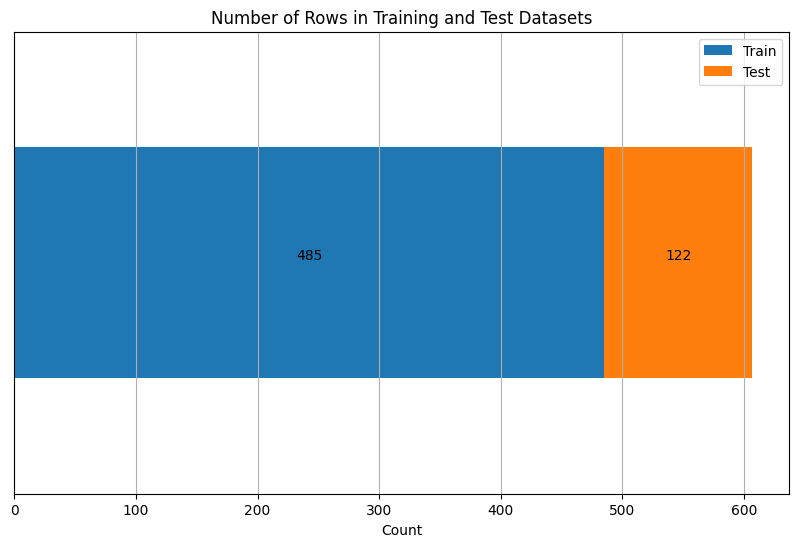

In [ ]:
# @markdown The graphic below shows the repartition of the sets.

# Count the number of rows in the training and test datasets
train_count = len(train_df)
test_count = len(test_df)

# Create a DataFrame with the counts
counts_df = pd.DataFrame({'Train': [train_count], 'Test': [test_count]})

# Create the plot
ax = counts_df.plot(kind='barh', stacked=True, figsize=(10,6))

# Add the counts on top of the bars
for rect in ax.patches:
    width = rect.get_width()
    ax.text(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2,
            int(width), ha='center', va='bottom')

plt.title('Number of Rows in Training and Test Datasets')
plt.xlabel('Count')
plt.grid(True)
plt.yticks([])
plt.show()

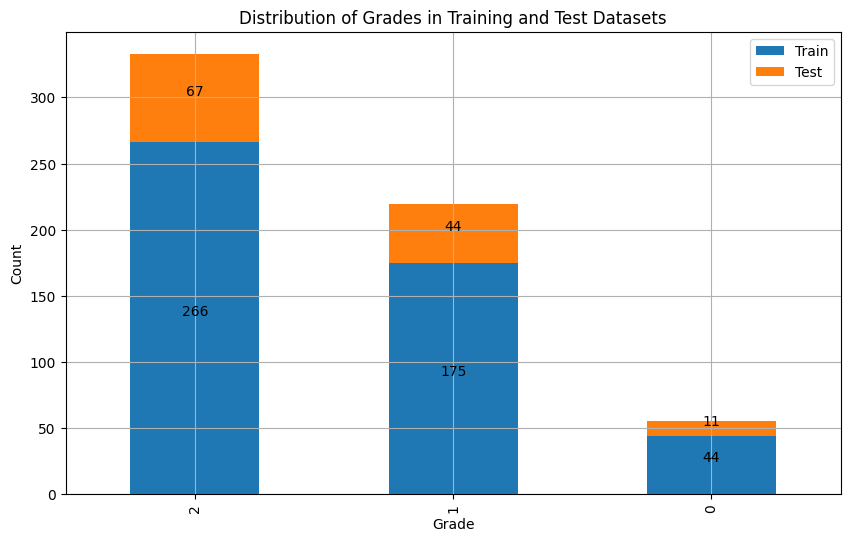

In [ ]:
# @markdown The next graphics illustrate the repartition of the attributed grades.

# Count the number of each grade in the training dataset
train_grade_counts = train_df['grades_round'].value_counts()

# Count the number of each grade in the test dataset
test_grade_counts = test_df['grades_round'].value_counts()

# Create a DataFrame with the counts
grade_counts_df = pd.DataFrame({'Train': train_grade_counts, 'Test': test_grade_counts})

# Create the plot
ax = grade_counts_df.plot(kind='bar', stacked=True, figsize=(10,6))

# Add the counts on top of the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
            int(height), ha='center', va='bottom')

plt.title('Distribution of Grades in Training and Test Datasets')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.grid(True)
plt.show()

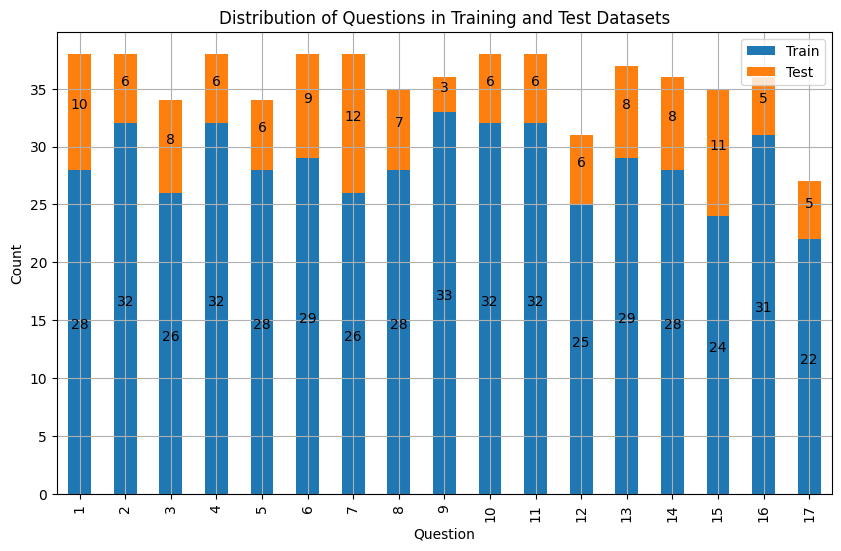

In [ ]:
# @markdown This graphics shows that every question of the dataset is present in both `train` and `test` subsets.

# Count the number of each question in the training dataset
train_question_counts = train_df['question_id'].value_counts()

# Count the number of each question in the test dataset
test_question_counts = test_df['question_id'].value_counts()

# Create a DataFrame with the counts
question_counts_df = pd.DataFrame({'Train': train_question_counts, 'Test': test_question_counts})

# Create the plot
ax = question_counts_df.plot(kind='bar', stacked=True, figsize=(10,6))

# Add the counts on top of the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
            int(height), ha='center', va='bottom')

plt.title('Distribution of Questions in Training and Test Datasets')
plt.xlabel('Question')
plt.ylabel('Count')
plt.grid(True)
plt.show()

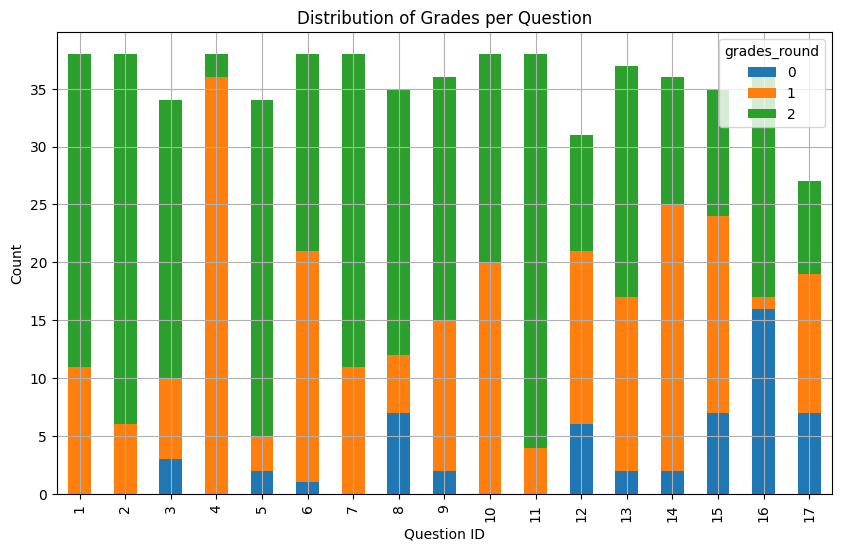

In [ ]:
# @markdown In the bar plot below, we illustrate the grade repartition per question.

# Group by 'question_id' and 'grades_round' and count the number of answers in each group
num_answers = df.groupby(['question_id', 'grades_round'])['student_answer'].count().unstack()

# Create the plot
num_answers.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Distribution of Grades per Question')
plt.xlabel('Question ID')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### Auxiliary functions

This section aimed to regroup all the functions used by the 3 LLM. You can read the code if you want to understand the exact implementation of the text generation, fine tuning...

In [ ]:
# Get loop iteration progress bar
def get_progress_bar(len):
    progress = Progress(
        TextColumn("[progress.description]{task.description}"),
        BarColumn(),
        TaskProgressColumn(),
        TextColumn("[green]Remaining"),
        TimeRemainingColumn(),
        TextColumn("[green]Elapsed"),
        TimeElapsedColumn()
    )

    task = progress.add_task("[green]Processing...", total=len)

    return progress, task

# Fixes JSON if needed and returns the value
def extract_json_value(json, key):
    try:
        response_dict = json_repair.loads(json)
        return response_dict.get(key)
    except Exception as e:
        print("Extract_json_value exception. Input:", json)
        return None

In [ ]:
# Plot sklearn classification_report and confusion_matrix on the same figure
def plot_classification_report_and_cm(y_true, y_pred, model_choice):
    assert len(y_true) == len(y_pred)

    # Create a DataFrame from the classification report
    report_df = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, zero_division=1.0)).transpose()

    # Format the remaining columns to two decimal places
    report_df = report_df.applymap(lambda x: "{:.2f}".format(x))

    # Convert the 'support' column to integers
    report_df['support'] = report_df['support'].str.split('.').str[0].astype(int)

    report_df.loc['accuracy', 'support'] = report_df.loc['macro avg', 'support']

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels = [0, 1, 2])

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

    # Add a main title
    fig.suptitle(f'{model_choice} Grades Evaluation', fontsize=16)

    # Create classification report table
    table = ax1.table(
        cellText=report_df.values,
        rowLabels=report_df.index,
        colLabels=report_df.columns,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    ax1.axis('off')
    ax1.set_title('Classification Report')

    # Create Seaborn heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

In [ ]:
# Preprocessing
stop_words = set(stopwords.words('english'))
def preprocess_feedback(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    return " ".join(filtered_text)

# Evaluation
def get_feedback_similarity(generated_feedback, actual_feedback):
    preprocessed_generated = preprocess_feedback(generated_feedback)
    preprocessed_actual = preprocess_feedback(actual_feedback)

    # Train Word2Vec model
    model = Word2Vec([preprocessed_generated.split(), preprocessed_actual.split()], min_count=1)

    # Get average vector for each feedback
    vector_generated = np.mean([model.wv[word] for word in preprocessed_generated.split()], axis=0)
    vector_actual = np.mean([model.wv[word] for word in preprocessed_actual.split()], axis=0)

    # Calculate cosine similarity
    similarity = 1 - cosine(vector_generated, vector_actual)

    return similarity

def plot_text_similarity_statistics(df1, df2):
    assert len(df1) == len(df2)

    similarities = []
    mismatched_indexes = []

    common_indexes = df1.index.intersection(df2.index)

    for idx in common_indexes:
        similarity = get_feedback_similarity(df1.loc[idx], df2.loc[idx])
        similarities.append(similarity)

    # Generate descriptive statistics
    stats = pd.Series(similarities).describe().round(2)
    stats_df = pd.DataFrame(stats)

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), width_ratios=[0.3, 0.7])

    # Add a main title
    fig.suptitle(f'{model_choice} Feedbacks Evaluation', fontsize=16)

    # Create statistics table
    table = ax1.table(cellText=stats_df.values,
                      colLabels=stats_df.columns,
                      rowLabels=stats_df.index,
                      cellLoc = 'center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)
    ax1.axis('off')
    ax1.set_title('Statistics')

    # Plot histogram
    ax2.hist(similarities, bins=20, alpha=0.5)
    ax2.set_title('Distribution of Cosine Similarities in Feedbacks')
    ax2.set_xlabel('Cosine Similarity')
    ax2.set_ylabel('Frequency')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

    # Find indexes present in df1 but not in df2 and vice versa
    df1_not_df2 = df1.index.difference(df2.index)
    df2_not_df1 = df2.index.difference(df1.index)

    if not df1_not_df2.empty or not df2_not_df1.empty:
        print("Indexes in df1 but not in df2: ", df1_not_df2.tolist())
        print("Indexes in df2 but not in df1: ", df2_not_df1.tolist())
        raise Exception("Indexes mismatch between df1 and df2")


In [ ]:
def extract_data_from_model_response(response, keys=[]):
    if type(response) != str:
      response = response.text
    response = response[response.find('{'):response.rfind('}') + 1]

    extracted_data = {}
    for key in keys:
        extracted_data[key] = extract_json_value(response, key)

    return extracted_data

def get_prompt(question, student_answer, ref_answer, prompt_type, examples_df=None, prompt_begining=False):
    base_prompt = f"""
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}
    """

    if prompt_type == '0shot':
        task_prompt = """
    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
    * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
    * **0:** Answer that does not capture the essence of the reference answer at all.

    2. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    3. Please generate a JSON response containing the grade and the feedback.
    """
    elif prompt_type == '0shot_cot':
        task_prompt = """
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.
    """
    elif prompt_type == 'fewshot_cot' or prompt_type == 'fewshot_cot_tuned':
        if examples_df is None or len(examples_df) < 1:
            raise Exception("At least one example is required for few-shot prompts")

        example_prompts = ""
        for _, example in examples_df.iterrows():
            example_prompts += f"""
    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}
    """

        task_prompt = f"""
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.

    {example_prompts}
    """

    if prompt_begining:
      return base_prompt + task_prompt + "\n## Response\n\n```json"
    else:
      return base_prompt + task_prompt

def test_model(prompt_type, results_df, model, model_choice, test_df=test_df, examples_df=None, debug_loop_limit=None, verbose=False, gemma=False):
    progress, task = get_progress_bar(len(test_df))

    results_grades_col_nm = f'{model_choice}_grade_{prompt_type}'
    results_feedbacks_col_nm = f'{model_choice}_feedback_{prompt_type}'

    if results_grades_col_nm in results_df.columns:
        results_df.drop([results_grades_col_nm], axis=1, inplace=True)

    if results_feedbacks_col_nm in results_df.columns:
        results_df.drop([results_feedbacks_col_nm], axis=1, inplace=True)

    with progress:
        for index, row in test_df.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return

            question = row['question']
            student_answer = row['student_answer']
            ref_answer= row['ref_answer']

            prompt = get_prompt(question, student_answer, ref_answer, prompt_type, examples_df=examples_df, prompt_begining=gemma)
            if model_choice == "Gemma":
                response = model.generate(prompt, max_length=1024)
            elif model_choice == "Fine tuned Gemma":
                response = model.generate(prompt, max_length=1024)
            elif model_choice == "Gemini":
                response = model.generate_content(prompt)
            else:
                raise Exception("Model '"+model_choice+"' not recognized.")

            response_data = extract_data_from_model_response(response, ["grade", "feedback"])
            grade = response_data["grade"]
            feedback = response_data["feedback"]

            if grade is not None:
                results_df.loc[index, results_grades_col_nm] = int(f'{grade}')
            else:
                results_df.loc[index, results_grades_col_nm] = grade

            results_df.loc[index, results_feedbacks_col_nm] = feedback

            progress.update(task, advance=1)

            if verbose:
                error = f", ❌ Index: {index}" if grade != row['grades_round'] else ""
                print(f"LLM Grade: {grade}, Dataset Grade: {row['grades_round']}{error}")

    results_df[results_grades_col_nm] = pd.to_numeric(results_df[results_grades_col_nm], errors='coerce', downcast='integer')

In [ ]:
def get_feedback_prompts(df=df, debug_loop_limit=None, rows=None):
    progress, task = get_progress_bar(len(df))

    feedback_prompts = []

    if rows is None:
        rows = df.index

    with progress:
        for index in rows:
            row = df.loc[index]
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return pd.concat(feedback_prompts, ignore_index=False)

            question = row['question']
            student_answer = row['student_answer']
            ref_answer= row['ref_answer']
            grades_round = row['grades_round']

            prompt = f"""
            ## Question:

            {question}

            ## Student Answer:

            {student_answer}

            ## Reference Answer:

            {ref_answer}

            ## Grade:

            {grades_round}

            ## Task:

            Grade can be between 0 and 2.

            1. Please analyze the student's answer in comparison to the reference answer and provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
            2. Feedback should be a phrase.
            3. Include assigned grade in feedback.
            4. Generate a JSON response containing the feedback.
            """

            prompt += "\n## Response\n\n```json"

            feedback_prompts.append(pd.DataFrame({'prompt': [prompt]}, index=[index]))

            progress.update(task, advance=1)
        return pd.concat(feedback_prompts, ignore_index=False)

def get_feedbacks(feedback_prompts, debug_loop_limit=None):
    progress, task = get_progress_bar(len(feedback_prompts))

    feedbacks = []

    with progress:
        for index, row in feedback_prompts.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return pd.concat(feedbacks, ignore_index=False)

            response = model.generate_content(row['prompt'])

            response_data = extract_data_from_model_response(response, ["grade", "feedback"])
            feedback = response_data["feedback"]

            feedbacks.append(pd.DataFrame({'feedback': [feedback]}, index=[index]))

            progress.update(task, advance=1)
        return pd.concat(feedbacks, ignore_index=False)

def construct_feedbacks(df, col_name='feedback'):
    if 'feedback' not in df.columns:
        df['feedback'] = None

    while True:
        null_indexes = pd.isnull(df[col_name]).where(lambda x: x).dropna().index

        if len(null_indexes) == 0:
            break

        lacking_feedback_prompts = get_feedback_prompts(df=df, rows=null_indexes)
        lacking_feedbacks = get_feedbacks(lacking_feedback_prompts)

        df.loc[lacking_feedbacks.index, col_name] = lacking_feedbacks[col_name]

    return df

In [ ]:
def evaluate_model_grades(prompt_type, results_df, model_choice, test_df=test_df):
    results_grades_col_nm = f'{model_choice}_grade_{prompt_type}'

    num_na = results_df[results_grades_col_nm].isna().sum()
    print(f"Percentage of NaN values in '{results_grades_col_nm}' that we omitted in metrics: {round((num_na / len(test_df)) * 100, 2)}%")

    # Filter out rows with NaN values in results_grades_col_nm
    results_df_filtered = results_df[results_df[results_grades_col_nm].notna()][[results_grades_col_nm]]

    # Filter out rows in test_df that are also in df_filtered
    test_df_filtered = test_df.loc[results_df_filtered.index]

    # Extract the true labels and predicted labels
    y_true = test_df_filtered['grades_round']
    y_pred = results_df_filtered[results_grades_col_nm]

    plot_classification_report_and_cm(y_true, y_pred, model_choice=model_choice)

def evaluate_model_feedbacks(prompt_type, results_df, model_choice, test_df=test_df):
    results_grades_col_nm = f'{model_choice}_feedback_{prompt_type}'

    num_na = results_df[results_grades_col_nm].isna().sum()
    print(f"Percentage of NaN values in '{results_grades_col_nm}' that we omitted in metrics: {round((num_na / len(test_df)) * 100, 2)}%")

    # Filter out rows with NaN values in results_grades_col_nm
    results_df_filtered = results_df[results_df[results_grades_col_nm].notna()][[results_grades_col_nm]]

    # Filter out rows in test_df that are also in df_filtered
    test_df_filtered = test_df.loc[results_df_filtered.index]

    # Extract the true labels and predicted labels
    y_true = test_df_filtered['feedback']
    y_pred = results_df_filtered[results_grades_col_nm]

    plot_text_similarity_statistics(y_true, y_pred)


In [ ]:
def get_training_data(train_df=train_df, debug_loop_limit=None, gemma=False):
    progress, task = get_progress_bar(len(train_df))

    training_data = []

    with progress:
        for index, row in train_df.iterrows():
            if debug_loop_limit is not None and progress.tasks[task].completed >= debug_loop_limit:
                return training_data

            question = row['question']
            student_answer = row['student_answer']
            ref_answer= row['ref_answer']
            grades_round = row['grades_round']
            feedback = row['feedback']

            prompt = get_prompt(question, student_answer, ref_answer, "0shot", prompt_begining=gemma)
            response = json.dumps({
                "grade": grades_round,
                "feedback": feedback,
            })

            training_data.append({
                'text_input': prompt,
                'output': response,
            })

            progress.update(task, advance=1)
        return training_data

## LLM

This section contains the 3 *Large Language Model (LLM)* implemented in this project. LLM aim to understand human language, generate text or do other tasks like classification.

Here all our models were chosen for their text generation ability. Allowing us to ask them to give a feedback and a grade at the same time, with specific prompts. We choose to solve the problem this way because we consider that separating grading and giving feedback tasks would lead to incoherent answers.

> Run only one at a time or restart the session before switching.

### Gemini

Gemini is a Multimodal LLM developped by Google. This last compagny use it as a chatbot, competiting with ChatGPT-4 from OpenAI.

We use a pretrained version of Gemini so we don't have to teach him human language ourselves.

#### Define model

In this section, we download and setup a pretrained Gemini model.

In [ ]:
# imports python SDK for the Gemini API
!pip install -q -U google-generativeai

import google.generativeai as genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.8/146.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.5/664.5 kB 39.4 MB/s eta 0:00:00


In [ ]:
# setup api key
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
print("Available models:")
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

Available models:


BadRequest: 400 GET https://generativelanguage.googleapis.com/v1beta/models?pageSize=50&%24alt=json%3Benum-encoding%3Dint: API key not valid. Please pass a valid API key.

In [ ]:
model_choice = "Gemini"

# define model
model = genai.GenerativeModel('gemini-pro')
model

In [ ]:
# Get model results file
try:
    results_df = pd.read_csv(f'Results/{model_choice}_results.csv', index_col=0)
except FileNotFoundError:
    results_df = pd.DataFrame()

#### Prompting

Here, we evaluate each kind of prompt.

In [ ]:
# @markdown You can specify the number of questions you want to evaluate the model on. A negative value means using the whole test set.

nb_questions = 5 # @param {type:"integer"}

if nb_questions > len(test_df):
  raise Exception("Please enter a number of question fewer than the dataset size ("+str(len(test_df))+"). You gave: "+str(nb_questions)+" .")
elif nb_questions <= 0:
  nb_questions = len(test_df)

##### **0 shot**

*0_shot* consists to simply ask the LLM to do a given task without providing any example.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}

    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
    * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
    * **0:** Answer that does not capture the essence of the reference answer at all.

    2. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    3. Please generate a JSON response containing the grade and the feedback.

In [ ]:
test_model("0shot", debug_loop_limit=nb_questions, results_df=results_df, model=model, model_choice=model_choice, verbose=True)

In [ ]:
results_df.head()

In [ ]:
evaluate_model_grades("0shot", results_df=results_df, model_choice=model_choice)

In [ ]:
evaluate_model_feedbacks("0shot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

##### **0 shot, CoT**

*Chain of Thought* consists to give reasoning steps to force the model to have a logical reflexion before answering.

Here, we combined *0 shot* and *CoT*.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}

     ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.

In [ ]:
test_model("0shot_cot", results_df=results_df, debug_loop_limit=nb_questions, model=model, model_choice=model_choice, verbose=True)

In [ ]:
results_df.head()

In [ ]:
evaluate_model_grades("0shot_cot", results_df=results_df, model_choice=model_choice)

In [ ]:
evaluate_model_feedbacks("0shot_cot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

##### **few shot, CoT**

*Few shot* consists to give examples for the tasks so the LLM could give inspire from them and better understand the what it has been ashed for.

For best results, we combined *few shot* and *CoT*.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}
    
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.


    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}


    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}

    ...

    ## Response

In [ ]:
examples_df = train_df[train_df['question_id'] == 1].groupby('grades_round').first().reset_index()

test_model("fewshot_cot", results_df=results_df, verbose=True, model=model, model_choice=model_choice, examples_df=examples_df, debug_loop_limit=nb_questions)

In [ ]:
results_df.head()

In [ ]:
evaluate_model_grades("fewshot_cot", results_df=results_df, model_choice=model_choice)

In [ ]:
evaluate_model_feedbacks("fewshot_cot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

### Gemma

Gemma is the open source version of Gemini. It was also developped by Google. We chose this model because everyone can fine-tune it.

We use a pretrained version of Gemma so we don't have to teach him human language ourselves.

#### Define model

In this section, we download and setup Gemma.

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [ ]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

import keras
import keras_nlp

# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.4/508.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible

In [ ]:
preset_gemma = "gemma_instruct_2b_en"
model = keras_nlp.models.GemmaCausalLM.from_preset(preset_gemma)
model.summary()

model_choice = "Gemma"

100%|██████████| 554/554 [00:00<00:00, 1.07MB/s]
100%|██████████| 4.67G/4.67G [01:50<00:00, 45.6MB/s]
100%|██████████| 401/401 [00:00<00:00, 230kB/s]
100%|██████████| 4.04M/4.04M [00:00<00:00, 8.13MB/s]


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Get model results file
try:
    results_df = pd.read_csv(f'Results/{model_choice}_results.csv', index_col=0)
except FileNotFoundError:
    results_df = pd.DataFrame()

#### Prompting

Here, we evaluate each kind of prompt.

Gemma's prompts are slightly different than Gemini's. Because of its text generator nature, Gemma is trying to continue the given prompt, by adding other tasks for example. We had to force it to realize the task by adding a field `## Response` containing the begining of a JSON file written in markdown:

    ```json

In [ ]:
# @markdown You can specify the number of questions you want to evaluate the model on. A negative value means using the whole test set.

nb_questions = 5 # @param {type:"integer"}

if nb_questions > len(test_df):
  raise Exception("Please enter a number of question fewer than the dataset size ("+str(len(test_df))+"). You gave: "+str(nb_questions)+" .")
elif nb_questions <= 0:
  nb_questions = len(test_df)

##### **0 shot**

*0_shot* consists to simply ask the LLM to do a given task without providing any example.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}

    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
    * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
    * **0:** Answer that does not capture the essence of the reference answer at all.

    2. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    3. Please generate a JSON response containing the grade and the feedback.

    ## Response

    ```json

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "0shot", prompt_begining=True)
gemma_output = model.generate(prompt, max_length=512)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

    Define: a hypothesis $h \in H$ shatters a dataset $A \subseteq X \Leftrightarrow \ldots$

    ## Student Answer:

    H shatters A when for example in given dataset (X1,X2...Xr) output are in a form (X1, Y1),(X2,Y2)...(Xr,Yr) there has been found a 0 error.

    ## Reference Answer:

    For all 2^N possible binary labeling of every data, if a hypothesis h splits the positive data from the negative data with no error, then it means that the hypothesis h shatters the dataset A.
    
    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
    * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains m

In [ ]:
test_model("0shot", debug_loop_limit=nb_questions, results_df=results_df, model=model, model_choice=model_choice, verbose=True, gemma=True)

Output()

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 128

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 381

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 262

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 549

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 452

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 137

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 484

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 560

LLM Grade: None, Dataset Grade: 2, ❌ Index: 168

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 109

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 152

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 464

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 204

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 611

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 212

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 275

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 1, ❌ Index: 344

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 378

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 592

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 31

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 32

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 559

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 422

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 449

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 546

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 476

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 140

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 232

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 544

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 248

LLM Grade: None, Dataset Grade: 2, ❌ Index: 347

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 466

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 561

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 188

LLM Grade: None, Dataset Grade: 2, ❌ Index: 63

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 102

LLM Grade: None, Dataset Grade: 2, ❌ Index: 341

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 161

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 93

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 0, ❌ Index: 284

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 626

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 371

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 191

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 385

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 418

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 416

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 582

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 172

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 353

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 628

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 471

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 558

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 507

LLM Grade: None, Dataset Grade: 2, ❌ Index: 87

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 457

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 264

LLM Grade: None, Dataset Grade: 2, ❌ Index: 66

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 213

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 211

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 135

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 229

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 624

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 139

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 206

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 85

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 294

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 258

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 72

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 588

LLM Grade: None, Dataset Grade: 2, ❌ Index: 105

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 327

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 426

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 458

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 541

In [ ]:
results_df.head()

,Gemma_grade_0shot_cot,Gemma_feedback_0shot_cot,Gemma_grade_fewshot_cot,Gemma_feedback_fewshot_cot,Gemma_grade_0shot,Gemma_feedback_0shot
499,2.0,The answer provides a good overview of the str...,2.0,The answer captures the essence of the referen...,2.0,The answer provides a good overview of the str...
128,2.0,The answer captures the essence of the referen...,2.0,The answer captures the essence of the referen...,2.0,The answer captures the essence of the referen...
22,2.0,The answer captures the essence of the referen...,2.0,The student's answer captures the essence of t...,2.0,The answer provides a good understanding of th...
35,2.0,The answer captures the essence of the referen...,2.0,The student's answer captures the essence of t...,2.0,The answer provides a basic definition of an a...
511,2.0,The answer provides a basic description of the...,2.0,The student's answer captures the essence of t...,2.0,The answer provides a basic description of the...


Percentage of NaN values in 'Gemma_grade_0shot' that we omitted in metrics: 9.84%


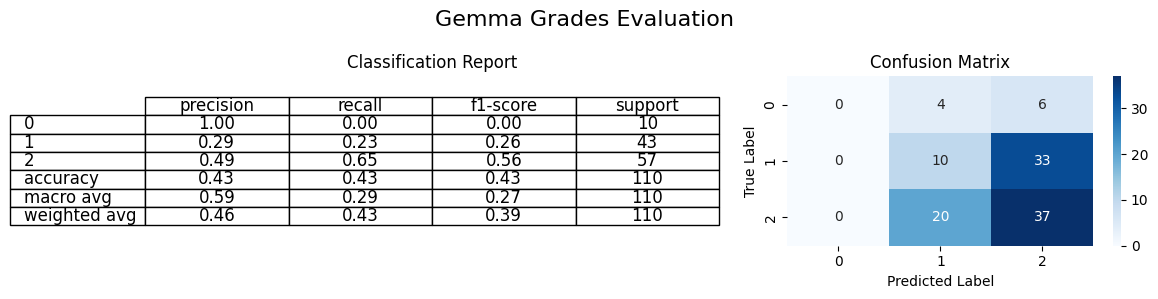

In [ ]:
evaluate_model_grades("0shot", results_df=results_df, model_choice=model_choice)

Percentage of NaN values in 'Gemma_feedback_0shot' that we omitted in metrics: 9.84%


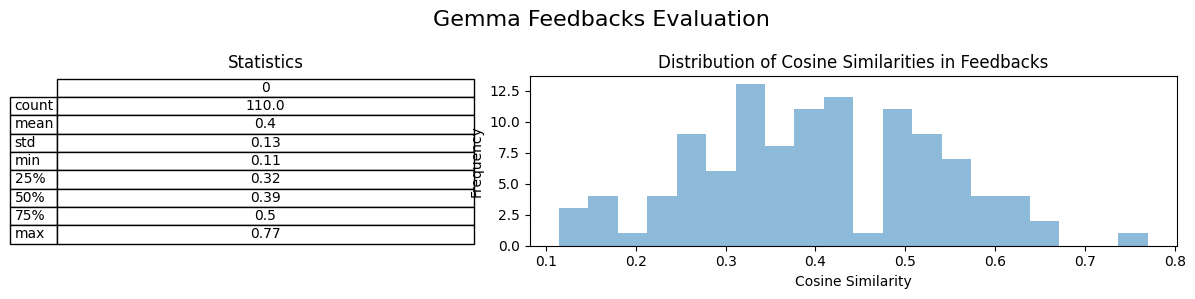

In [ ]:
evaluate_model_feedbacks("0shot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

##### **0 shot, CoT**

*Chain of Thought* consists to give reasoning steps to force the model to have a logical reflexion before answering.

Here, we combined *0 shot* and *CoT*.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}

     ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.

    ## Response

    ```json

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "0shot_cot", prompt_begining=True)
gemma_output = model.generate(prompt, max_length=512)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

    Write down and explain the Widrow-Hoff learning rule!

    ## Student Answer:

    Windrow-Hoff or error correction learning rule says that the adjustment of a weight is proportional to the product of the error signal and the input signal of the weight.

    ## Reference Answer:

    The adjustment made to a synaptic weight of a neuron is proportional to the product of the error signal and the input signal of the synapse in question. The rule is derived from the steepest descent method.
    
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given 

In [ ]:
test_model("0shot_cot", results_df=results_df, debug_loop_limit=nb_questions, model=model, model_choice=model_choice, verbose=True, gemma=True)

Output()

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 128

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 300

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 262

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 549

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 452

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 598

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 137

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 484

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 77

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 270

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 276

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 560

LLM Grade: None, Dataset Grade: 2, ❌ Index: 168

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 109

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 152

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 464

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 204

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 611

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 212

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 275

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 1, ❌ Index: 344

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 378

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 592

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 31

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 32

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 603

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 559

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 422

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 449

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 546

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 476

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 140

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 232

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 544

LLM Grade: 1, Dataset Grade: 1

LLM Grade: None, Dataset Grade: 2, ❌ Index: 347

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 466

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 561

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 188

LLM Grade: None, Dataset Grade: 2, ❌ Index: 63

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 405

LLM Grade: None, Dataset Grade: 2, ❌ Index: 102

LLM Grade: None, Dataset Grade: 2, ❌ Index: 341

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 161

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 93

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 281

LLM Grade: None, Dataset Grade: 0, ❌ Index: 284

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 626

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 371

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 191

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 416

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 582

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 57

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 172

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 353

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 628

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 471

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 558

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 507

LLM Grade: None, Dataset Grade: 2, ❌ Index: 87

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 264

LLM Grade: None, Dataset Grade: 2, ❌ Index: 66

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 213

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 534

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 211

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 234

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 135

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 229

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 624

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 139

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 206

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 294

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 258

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 72

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 588

LLM Grade: None, Dataset Grade: 2, ❌ Index: 105

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 426

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 458

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 541

In [ ]:
results_df.head()

,Gemma_grade_fewshot_cot,Gemma_feedback_fewshot_cot,Gemma_grade_0shot,Gemma_feedback_0shot,Gemma_grade_0shot_cot,Gemma_feedback_0shot_cot
499,2.0,The answer captures the essence of the referen...,2.0,The answer provides a good overview of the str...,2.0,The answer provides a good overview of the str...
128,2.0,The answer captures the essence of the referen...,2.0,The answer captures the essence of the referen...,2.0,The answer captures the essence of the referen...
22,2.0,The student's answer captures the essence of t...,2.0,The answer provides a good understanding of th...,2.0,The answer captures the essence of the referen...
35,2.0,The student's answer captures the essence of t...,2.0,The answer provides a basic definition of an a...,2.0,The answer captures the essence of the referen...
511,2.0,The student's answer captures the essence of t...,2.0,The answer provides a basic description of the...,2.0,The answer provides a basic description of the...


Percentage of NaN values in 'Gemma_grade_0shot_cot' that we omitted in metrics: 9.84%


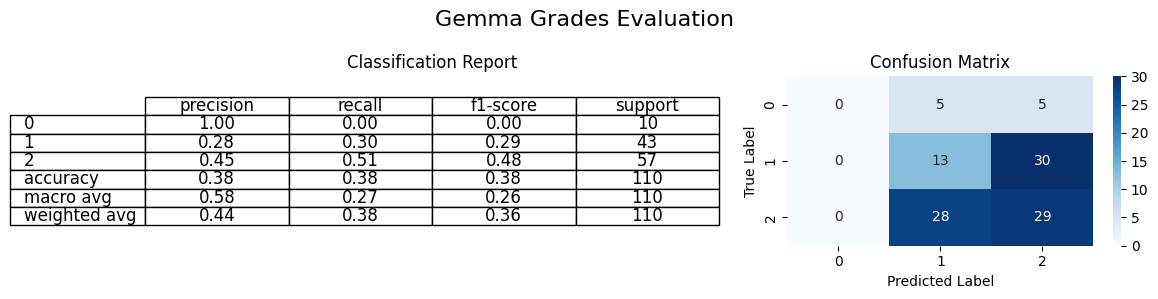

In [ ]:
evaluate_model_grades("0shot_cot", results_df=results_df, model_choice=model_choice)

Percentage of NaN values in 'Gemma_feedback_0shot_cot' that we omitted in metrics: 9.84%


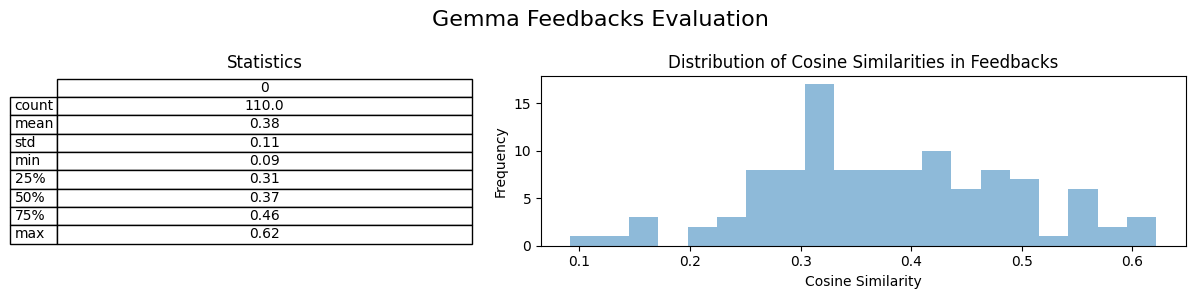

In [ ]:
evaluate_model_feedbacks("0shot_cot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

##### **few shot, CoT**

*Few shot* consists to give examples for the tasks so the LLM could give inspire from them and better understand the what it has been ashed for.

For best results, we combined *few shot* and *CoT*.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}
    
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.


    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}


    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}

    ...

    ## Response

    ```json

In [ ]:
examples_df = train_df[train_df['question_id'] == 1].groupby('grades_round').first().reset_index()

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "fewshot_cot", examples_df, prompt_begining=True)
gemma_output = model.generate(prompt, max_length=1024)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

    Describe: the structure on an CNN.

    ## Student Answer:

    The structure is as follows: -Convolution: In this layer convolution takes place instead of matrix multiplication -Deconvolution: In this layer deconvolution takes place , by matrix multiplication -Average weight layer: This is a max pooling layer

    ## Reference Answer:

    Convolutional Neural Network consists of many layers such as a convolutional layer that has kernels which convolve over the input image, an activation layer (ReLU activation), pooling layer (max or average pooling), and one or more fully connected layers followed by softmax layer.
    
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context

In [ ]:
test_model("fewshot_cot", results_df=results_df, verbose=True, model=model, model_choice=model_choice, examples_df=examples_df, debug_loop_limit=nb_questions, gemma=True)

Output()

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 128

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 381

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 382

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 515

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 262

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 549

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 452

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 598

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 137

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 484

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 77

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 506

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 560

LLM Grade: None, Dataset Grade: 2, ❌ Index: 168

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 109

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 204

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 212

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 1, ❌ Index: 344

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 378

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 31

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 32

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 603

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 559

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 449

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 546

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 140

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 232

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 544

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 248

LLM Grade: None, Dataset Grade: 2, ❌ Index: 347

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 634

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 561

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 188

LLM Grade: None, Dataset Grade: 2, ❌ Index: 63

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 102

LLM Grade: None, Dataset Grade: 2, ❌ Index: 341

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 161

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 93

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 0, ❌ Index: 284

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 371

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 191

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 385

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 416

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 582

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 172

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 353

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 558

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 507

LLM Grade: None, Dataset Grade: 2, ❌ Index: 87

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 264

LLM Grade: None, Dataset Grade: 2, ❌ Index: 66

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 213

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 534

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 521

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 211

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 135

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 229

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 624

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 206

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 294

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 72

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 588

LLM Grade: None, Dataset Grade: 2, ❌ Index: 105

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 327

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 426

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 474

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 141

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 541

In [ ]:
results_df.head()

,Gemma_grade_0shot,Gemma_feedback_0shot,Gemma_grade_0shot_cot,Gemma_feedback_0shot_cot,Gemma_grade_fewshot_cot,Gemma_feedback_fewshot_cot
499,2.0,The answer provides a good overview of the str...,2.0,The answer provides a good overview of the str...,2.0,The answer captures the essence of the referen...
128,2.0,The answer captures the essence of the referen...,2.0,The answer captures the essence of the referen...,2.0,The answer captures the essence of the referen...
22,2.0,The answer provides a good understanding of th...,2.0,The answer captures the essence of the referen...,2.0,The student's answer captures the essence of t...
35,2.0,The answer provides a basic definition of an a...,2.0,The answer captures the essence of the referen...,2.0,The student's answer captures the essence of t...
511,2.0,The answer provides a basic description of the...,2.0,The answer provides a basic description of the...,2.0,The student's answer captures the essence of t...


Percentage of NaN values in 'Gemma_grade_fewshot_cot' that we omitted in metrics: 9.84%


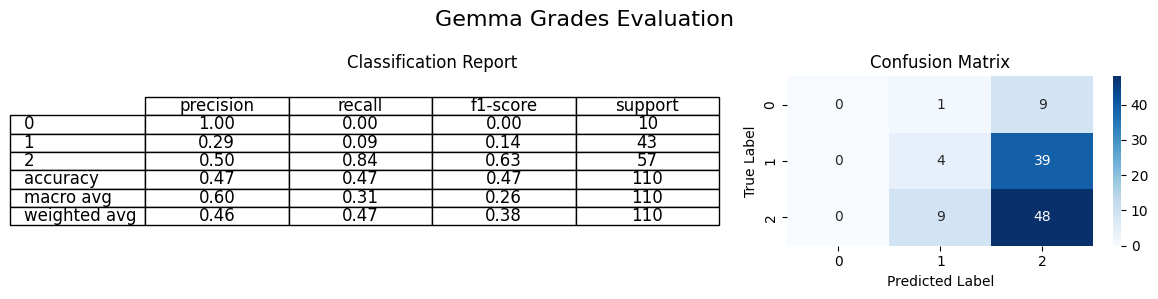

In [ ]:
evaluate_model_grades("fewshot_cot", results_df=results_df, model_choice=model_choice)

Percentage of NaN values in 'Gemma_feedback_fewshot_cot' that we omitted in metrics: 9.84%


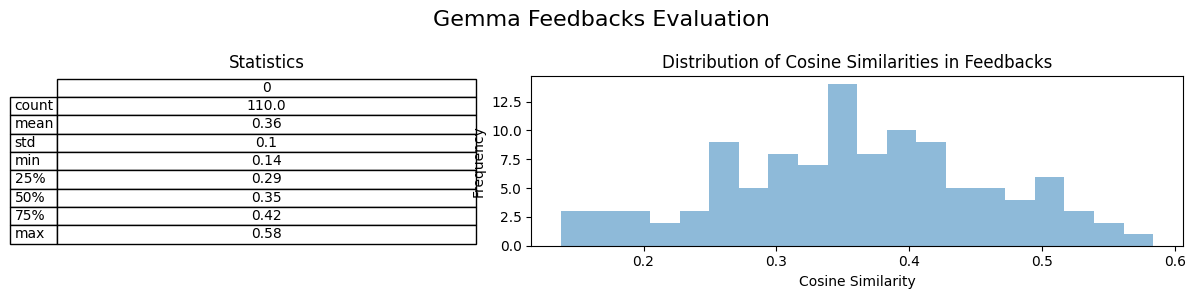

In [ ]:
evaluate_model_feedbacks("fewshot_cot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

### Fined tuned Gemma

To get better responses from Gemma, we fine-tune the model with our dataset. Gemma can be easily fine tuned because it is open source, in opposite to Gemini.

#### Define model

In this section, we download and setup Gemma.

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [ ]:
!pip install -q -U keras-nlp
!pip install -q -U keras>=3

import keras
import keras_nlp

# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.

In [ ]:
preset_gemma = "gemma_instruct_2b_en"
model = keras_nlp.models.GemmaCausalLM.from_preset(preset_gemma)
model.backbone.enable_lora(rank=2)
model.summary()

model_choice = "Fine tuned Gemma"

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,854,400 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,854,400 (9.34 GB)

 Trainable params: 681,984 (2.60 MB)

 Non-trainable params: 2,506,172,416 (9.34 GB)

In [ ]:
# Get model results file
try:
    results_df = pd.read_csv(f'Results/{model_choice}_results.csv', index_col=0)
except FileNotFoundError:
    results_df = pd.DataFrame()

#### Fine tuning

In this section, we fine tune Gemma on our own dataset.

In [ ]:
# @title Preparing dataset

# @markdown The train dataset need to be turned into a list of expected outputs to train the model. Gemma learn to reproduce text so we feed it with prompts and feedbacks. Because we don't have any feedback, we use the reference answer as a feedback. This should push the model to correct the students' mistakes.

# @markdown An example is displayed below.

def df_to_finetuning_dataset(df, prompt_type="0shot"):
  """
  Turn a pandas DataFrame into a dataset usuable for Gemma fine tuning.

  #### Parameters:
  :df: pandas DataFrame
  :prompt_type: Select one of the listed prompting options:
    - "0shot": 0 shot prompt
    - "0shot_cot": 0 shot and chain of thought prompt
  """
  data = []

  for _, row in df.iterrows():
    prompt = get_prompt(row["question"], row["student_answer"], row["ref_answer"], prompt_type, prompt_begining=True)

    expected_answer = """
{
  "grade": """
    expected_answer += str(row["grades_round"])
    expected_answer += """,
  "feedback": """
    expected_answer += '"'+str(row["feedback"])+'"'
    expected_answer += """
}
```"""
    data.append(prompt+expected_answer)

  return data

data = df_to_finetuning_dataset(train_df)
print(data[0])


    ## Question:

    Write down the SOM learning in pseudo code.

    ## Student Answer:

    input: distance function d(x, y), learning rate mu, neighborhood distance n Initialize the map layer with random weights for each input: find the weight which is closest to the input (minimum d(x, y)) change the weight in the direction of the input depending on the learning rate change all weights which are within the neighborhood distance n depending on their distance and the learning rate reduce learning rate and neighborhood distance

    ## Reference Answer:

    Arrange the weights in the required topology according to the problem. Initialize the weights randomly such that all the weights are different. Sample the input from the input space. Similarity matching: match the input to a neuron in the topological lattice which becomes the winning neuron. Update the weights of the winning neuron and its neighbours determined by the neighbourhood function. Reduce the neighbourhood and decay th

In [ ]:
# @title Training

# @markdown Now that the dataset is ready, we can fine tune Gemma. Because of the low accorded RAM and the long computation time, we couldn't train the model over more than 1 epoch. This still has an impact on Gemma performance.

# Limit the input sequence length to 512 (to control memory usage).
model.preprocessor.sequence_length = 256 # 512 provocate Out Of Memory
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(data, epochs=1, batch_size=1)

485/485 ━━━━━━━━━━━━━━━━━━━━ 555s 813ms/step - loss: 2.8688 - sparse_categorical_accuracy: 0.5143


In [ ]:
# @markdown We set back the model into generation mode after the training.
model.preprocessor.sequence_length = 1024 # After fine tuning, we change sequence length back to 1024.

#### Prompting

Here, we evaluate each kind of prompt.

Gemma's prompts are slightly different than Gemini's. Because of its text generator nature, Gemma is trying to continue the given prompt, by adding other tasks for example. We had to force it to realize the task by adding a field `## Response` containing the begining of a JSON file written in markdown:

    ```json

In [ ]:
# @markdown You can specify the number of questions you want to evaluate the model on. A negative value means using the whole test set.

nb_questions = 5 # @param {type:"integer"}

if nb_questions > len(test_df):
  raise Exception("Please enter a number of question fewer than the dataset size ("+str(len(test_df))+"). You gave: "+str(nb_questions)+" .")
elif nb_questions <= 0:
  nb_questions = len(test_df)

##### **0 shot**

*0_shot* consists to simply ask the LLM to do a given task without providing any example.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}

    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
    * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
    * **0:** Answer that does not capture the essence of the reference answer at all.

    2. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    3. Please generate a JSON response containing the grade and the feedback.

    ## Response

    ```json

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "0shot", prompt_begining=True)
gemma_output = model.generate(prompt, max_length=512)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

    Explain classification and regression; what is the difference?

    ## Student Answer:

    Classification is the task of classifying the input signals into a finite number of groups, so the output is a number that indicates a certain class. Regression is the task of approximating a function by estimating the values given the input signals, so the output can be any real number.

    ## Reference Answer:

    Classification is a task of mapping data to discrete labels while regression is a task which maps data to a continuous function or real values. Error in classification is the number of misclassifications while in regression is the summed distance between the true and predicted values. 
    
    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that ca

In [ ]:
test_model("0shot", debug_loop_limit=nb_questions, results_df=results_df, model=model, model_choice=model_choice, verbose=True, gemma=True)

Output()

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 128

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 182

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 381

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 382

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 515

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 262

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 549

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 452

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 80

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 137

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 484

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 506

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 560

LLM Grade: None, Dataset Grade: 2, ❌ Index: 168

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 204

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 212

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 1, ❌ Index: 344

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 378

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 31

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 32

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 559

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 449

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 546

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 140

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 232

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 544

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 248

LLM Grade: None, Dataset Grade: 2, ❌ Index: 347

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 634

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 561

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 63

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 102

LLM Grade: None, Dataset Grade: 2, ❌ Index: 341

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 0, ❌ Index: 284

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 371

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 191

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 385

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 582

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 172

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 353

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 558

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 507

LLM Grade: None, Dataset Grade: 2, ❌ Index: 87

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 264

LLM Grade: None, Dataset Grade: 2, ❌ Index: 66

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 213

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 534

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 521

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 211

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 135

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 229

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 624

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 139

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 206

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 85

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 294

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 72

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 588

LLM Grade: None, Dataset Grade: 2, ❌ Index: 105

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 327

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 426

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 474

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 541

In [ ]:
results_df.head()

,Fine tuned Gemma_grade_fewshot_cot,Fine tuned Gemma_feedback_fewshot_cot,Fine tuned Gemma_grade_0shot_cot,Fine tuned Gemma_feedback_0shot_cot,Fine tuned Gemma_grade_0shot,Fine tuned Gemma_feedback_0shot
499,2.0,The student captures the essence of the refere...,2.0,"Understand the structure of a CNN, but the stu...",2.0,The answer captures the essence of the referen...
128,2.0,The student captures the essence of the refere...,2.0,Understand the difference between classificati...,2.0,The answer captures the essence of the referen...
22,2.0,Answer captures the essence of the reference a...,1.0,Answer captures the essence of the reference a...,2.0,Answer captures the essence of the reference a...
35,2.0,Answer captures the essence of the reference a...,NaN,NaN,2.0,Answer captures the essence of the reference a...
511,2.0,The student captures the essence of the refere...,2.0,"Understand the structure of CNN, student misse...",2.0,The answer captures the essence of the referen...


Percentage of NaN values in 'Fine tuned Gemma_grade_0shot' that we omitted in metrics: 9.84%


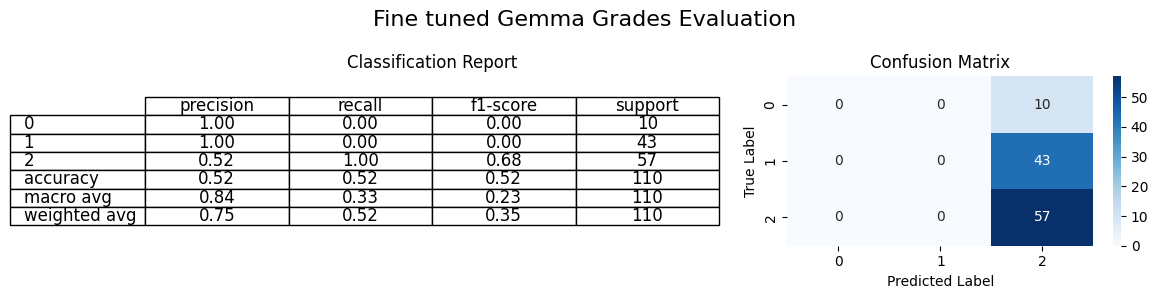

In [ ]:
evaluate_model_grades("0shot", results_df=results_df, model_choice=model_choice)

Percentage of NaN values in 'Fine tuned Gemma_feedback_0shot' that we omitted in metrics: 9.84%


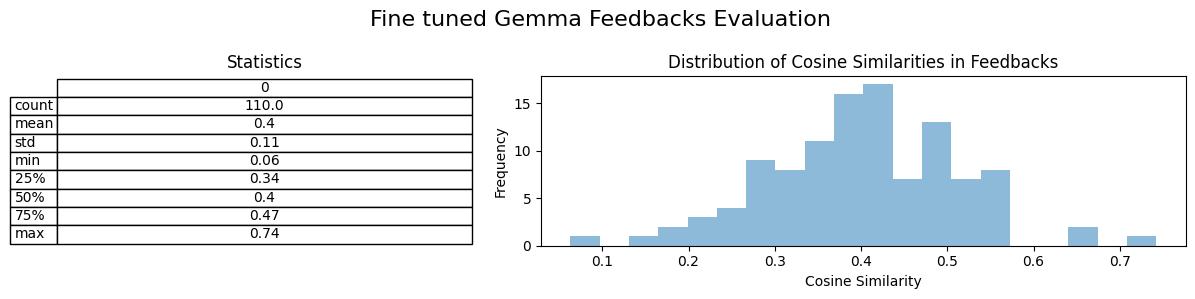

In [ ]:
evaluate_model_feedbacks("0shot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

##### **0 shot, CoT**

*Chain of Thought* consists to give reasoning steps to force the model to have a logical reflexion before answering.

Here, we combined *0 shot* and *CoT*.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}

     ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.

    ## Response

    ```json

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "0shot_cot", prompt_begining=True)
gemma_output = model.generate(prompt, max_length=1024)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

    What are three items to be learned for an RBF network? Difference to other NNs, Pros/cons?

    ## Student Answer:

    1. Weigths in the network 2. the center of the clusters 3. variation of the cluster ($\sigma$) Difference: RBF always have only three layers RBF can also trained in an unspervised method RBF can also approximate any continuous function

    ## Reference Answer:

    Three items to be learned are centers, weights, and biases. RBFN consists of a single hidden layer and a linear output layer. NN can have multiple hidden layers and a linear or non-linear output layer. Pros: RBFN is a universal approximator and it is easy to add more centers. Con: The bias is not unique.  
    
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

   

In [ ]:
test_model("0shot_cot", results_df=results_df, debug_loop_limit=nb_questions, model=model, model_choice=model_choice, verbose=True, gemma=True)

Output()

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 128

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 182

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 381

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 382

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 515

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 262

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 549

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 452

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 137

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 484

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 506

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 560

LLM Grade: None, Dataset Grade: 2, ❌ Index: 168

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 204

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 611

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 212

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 1, ❌ Index: 344

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 378

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 31

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 32

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 559

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 449

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 546

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 140

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 544

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 248

LLM Grade: None, Dataset Grade: 2, ❌ Index: 347

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 561

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 63

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 102

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 0, ❌ Index: 284

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 626

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 371

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 191

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 385

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 582

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: None, Dataset Grade: 2, ❌ Index: 172

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 353

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 628

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 558

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 507

LLM Grade: None, Dataset Grade: 2, ❌ Index: 87

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 264

LLM Grade: None, Dataset Grade: 2, ❌ Index: 66

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 213

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 534

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 521

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 211

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 135

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 229

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 624

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 139

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 206

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 85

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 294

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 258

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 72

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 588

LLM Grade: None, Dataset Grade: 2, ❌ Index: 105

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 327

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 426

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 474

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 541

In [ ]:
results_df.head()

,Fine tuned Gemma_grade_fewshot_cot,Fine tuned Gemma_feedback_fewshot_cot,Fine tuned Gemma_grade_0shot,Fine tuned Gemma_feedback_0shot,Fine tuned Gemma_grade_0shot_cot,Fine tuned Gemma_feedback_0shot_cot
499,2.0,The student captures the essence of the refere...,2.0,The answer captures the essence of the referen...,2.0,"Understand the structure of CNN, the main idea..."
128,2.0,The student captures the essence of the refere...,2.0,The answer captures the essence of the referen...,2.0,Understand the difference between classificati...
22,2.0,Answer captures the essence of the reference a...,2.0,Answer captures the essence of the reference a...,2.0,"Understand the concept of an ANN, but the answ..."
35,2.0,Answer captures the essence of the reference a...,2.0,Answer captures the essence of the reference a...,2.0,"Understand the concept of an ANN, the main ide..."
511,2.0,The student captures the essence of the refere...,2.0,The answer captures the essence of the referen...,2.0,"Understand the structure of CNN, the main idea..."


Percentage of NaN values in 'Fine tuned Gemma_grade_0shot_cot' that we omitted in metrics: 9.84%


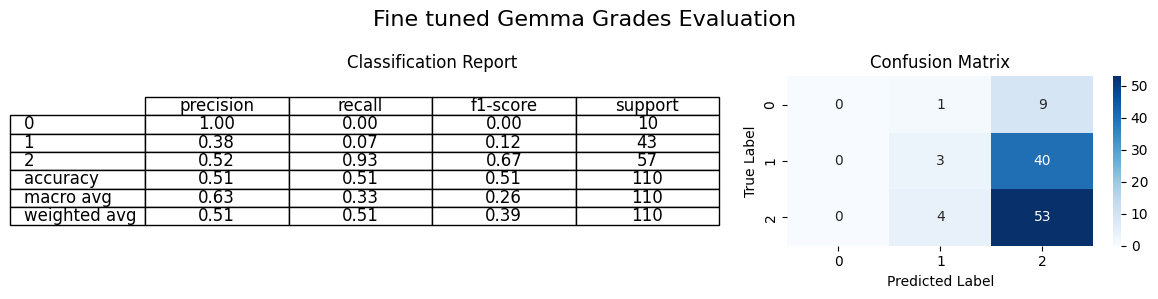

In [ ]:
evaluate_model_grades("0shot_cot", results_df=results_df, model_choice=model_choice)

Percentage of NaN values in 'Fine tuned Gemma_feedback_0shot_cot' that we omitted in metrics: 9.84%


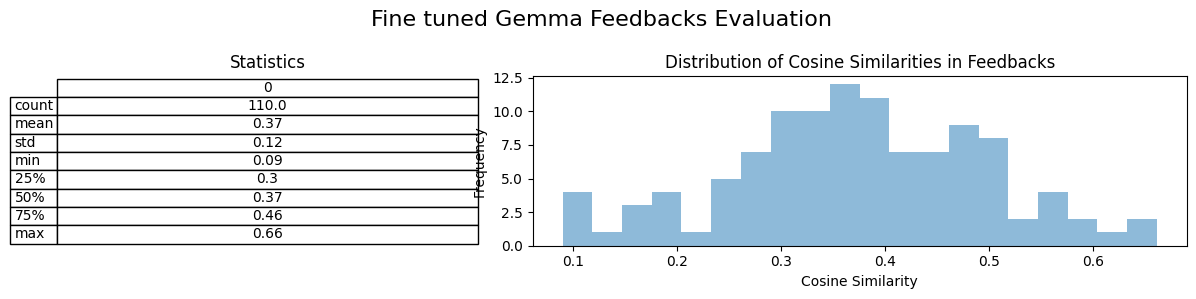

In [ ]:
evaluate_model_feedbacks("0shot_cot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

##### **few shot, CoT**

*Few shot* consists to give examples for the tasks so the LLM could give inspire from them and better understand the what it has been ashed for.

For best results, we combined *few shot* and *CoT*.

Used prompt:
    ## Question:

    {question}

    ## Student Answer:

    {student_answer}

    ## Reference Answer:

    {ref_answer}
    
    ## Task:

    1. Read the question, student's answer, and the reference answer.

    2. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    3. Consider the context of the question and answer.
    * The context can include the subject matter, the level of detail required by the question, and the appropriateness of the student's answer given the question.

    4. Consider the following grading scheme:
        * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
        * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
        * **0:** Answer that does not capture the essence of the reference answer at all.

    5. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    6. Please generate a JSON response containing the grade and the feedback.


    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}


    ## Example:

    ### Question:

    {example['question']}

    ### Student Answer:

    {example['student_answer']}

    ### Reference Answer:

    {example['ref_answer']}

    ### Grade:

    {example['grades_round']}

    ...

    ## Response

    ```json

In [ ]:
examples_df = train_df[train_df['question_id'] == 1].groupby('grades_round').first().reset_index()

In [ ]:
qa_example = test_df.sample()
prompt = get_prompt(qa_example["question"].values[0], qa_example["student_answer"].values[0], qa_example["ref_answer"].values[0], "fewshot_cot", examples_df, prompt_begining=True)
gemma_output = model.generate(prompt, max_length=1024)
print(gemma_output)
print("\n\nTrue mark:",qa_example["grades_round"].values[0])


    ## Question:

    Explain back propagation, use the correct technical terms!

    ## Student Answer:

    * Back propagation is a process to make adjustment to the weights of a neural network in a way that minimizes the average squared error of the training data. * It uses steepest decent method. In each step it moves towards the direction that gives maximum decrease of the error. * In back propagation the error is propaged backward from the last layer towards the earlier layers. The adjustments made to the weights is proportional to the partial derivative of the error with respect to the weight. * The partial derivative is calculated using repeated application of the chain rule.

    ## Reference Answer:

    Backpropagation lowers the error of a MLP level by level recursively backwards. It back propagates an error from the last layer to the first layer by updating the weights. The updates are determined by the local gradient at each level which is computed by partial derivatives

In [ ]:
test_model("fewshot_cot", results_df=results_df, verbose=True, model=model, model_choice=model_choice, examples_df=examples_df, debug_loop_limit=nb_questions, gemma=True)

Output()

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 499

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 511

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 300

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 515

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 203

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 549

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 452

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 249

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 598

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 484

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 77

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 270

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 506

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 276

LLM Grade: 1, Dataset Grade: 1

LLM Grade: None, Dataset Grade: 2, ❌ Index: 168

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 109

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 152

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 464

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 204

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 611

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 212

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 275

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 536

LLM Grade: None, Dataset Grade: 1, ❌ Index: 344

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 228

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 247

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 378

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 592

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 31

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 32

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 603

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 263

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 449

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 546

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 372

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 476

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 248

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 188

LLM Grade: None, Dataset Grade: 2, ❌ Index: 63

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 405

LLM Grade: None, Dataset Grade: 2, ❌ Index: 102

LLM Grade: None, Dataset Grade: 2, ❌ Index: 341

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 161

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 93

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 281

LLM Grade: None, Dataset Grade: 0, ❌ Index: 284

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 626

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 425

LLM Grade: None, Dataset Grade: 2, ❌ Index: 371

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 418

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 416

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 75

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 582

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 210

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 399

LLM Grade: None, Dataset Grade: 2, ❌ Index: 172

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 628

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 471

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 0, ❌ Index: 507

LLM Grade: None, Dataset Grade: 2, ❌ Index: 87

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 264

LLM Grade: None, Dataset Grade: 2, ❌ Index: 66

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 501

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 213

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 521

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 234

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 624

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 311

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 206

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 219

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 294

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 258

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 588

LLM Grade: None, Dataset Grade: 2, ❌ Index: 105

LLM Grade: 2, Dataset Grade: 1, ❌ Index: 327

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 1

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 243

LLM Grade: 1, Dataset Grade: 2, ❌ Index: 141

LLM Grade: 2, Dataset Grade: 2

LLM Grade: 1, Dataset Grade: 0, ❌ Index: 541

In [ ]:
results_df.head()

,Fine tuned Gemma_grade_0shot,Fine tuned Gemma_feedback_0shot,Fine tuned Gemma_grade_0shot_cot,Fine tuned Gemma_feedback_0shot_cot,Fine tuned Gemma_grade_fewshot_cot,Fine tuned Gemma_feedback_fewshot_cot
499,2.0,The answer captures the essence of the referen...,2.0,"Understand the structure of CNN, the main idea...",1.0,The student provides a basic definition of an ...
128,2.0,The answer captures the essence of the referen...,2.0,Understand the difference between classificati...,1.0,The student provides a definition of an artifi...
22,2.0,Answer captures the essence of the reference a...,2.0,"Understand the concept of an ANN, but the answ...",2.0,The student captures the essence of the refere...
35,2.0,Answer captures the essence of the reference a...,2.0,"Understand the concept of an ANN, the main ide...",2.0,The student captures the essence of the refere...
511,2.0,The answer captures the essence of the referen...,2.0,"Understand the structure of CNN, the main idea...",2.0,The student captures the essence of the refere...


Percentage of NaN values in 'Fine tuned Gemma_grade_fewshot_cot' that we omitted in metrics: 9.84%


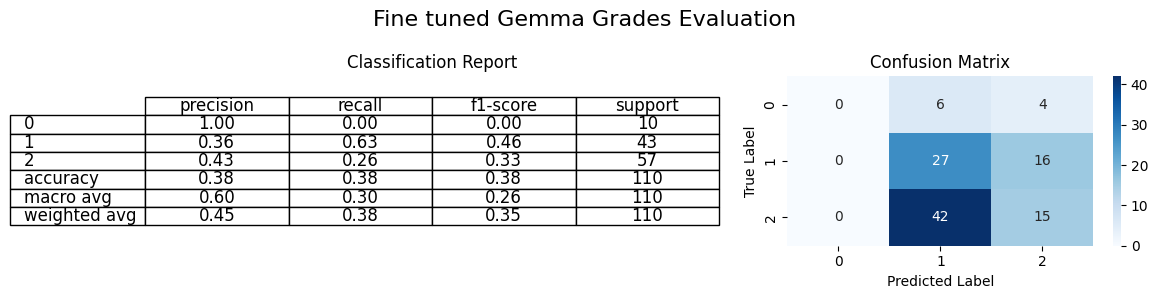

In [ ]:
evaluate_model_grades("fewshot_cot", results_df=results_df, model_choice=model_choice)

Percentage of NaN values in 'Fine tuned Gemma_feedback_fewshot_cot' that we omitted in metrics: 9.84%


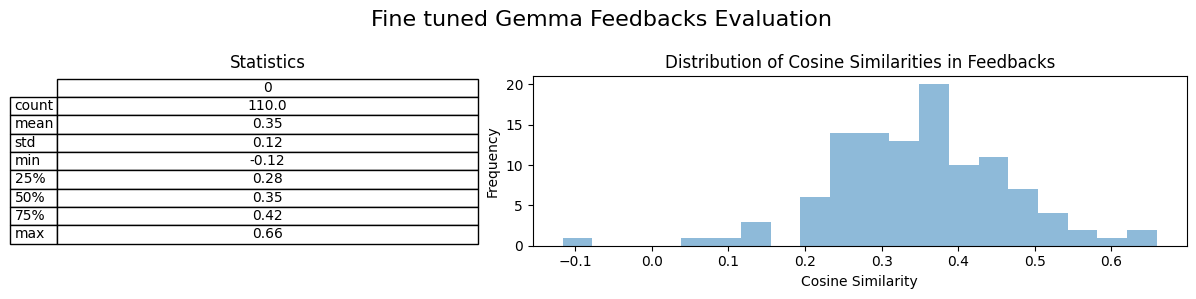

In [ ]:
evaluate_model_feedbacks("fewshot_cot", results_df=results_df, model_choice=model_choice)

In [ ]:
results_df.to_csv(f'Results/{model_choice}_results.csv')

## Analysis

### Comparison

In this section, we compare the above LLM and their prompts.

The LLMs tested are:
- Gemini (Google)
- Gemma (Meta)
- Gemma fine-tuned

#### Prompts

Prompt engineering is really important to exploit the full potentiel of a LLM. In this section, we'll compare those used in the project:
- *0 shot*
- *Chain of Thought (CoT)*
- *Few shot*

The *0 shot* prompt is shorter than the others and gives more freedom to the LLM. Its outputs are then less biased by the prompt.

It seems that the *Chain Of Thoughts* didn't really improve the feedbacks even though this method should have made them longer and more accurate. Indeed, *0 shot* alone produced better feedbacks than with *CoT*.

Despite the accuracy of the *Few shot* prompt, the generated feedbacks aren't better than the *0 shot* prompting. Indeed, the feedbacks are shorter with few shots. This can be explained by several factors:
- the prompts itself, that doesn't show any feedback example
- the reference answer, that isn't always correctly formulated and might have been interpreted as a feedback example
- the size of the prompt, which is often limited and force the model to reduce its answer, making its feedback poorer

Beyond the performance, prompting can avoid LLM mistakes. We observed that one of our model sometimes missed characters.

```
    ## Question:

    Write down and explain the Widrow-Hoff learning rule!

    ## Student Answer:

    $$ \Delta w(n) = \eta * e(n)*w(n) $$ $$ e(n) = (y-d) $$ The widrow hoff learning rule is error correction learning. It is used to train a network in a supervised manner. The widrow hoff learning rule can be derived from gradient decent. The rule consists of the error e(n) the neuron has and is muliplied with the weight so that the impact of the weight to the error is incorporated into the update. A learning rule is use as a adjustment in how much we trust the weight change. The error is calculate by the difference between the current and expected output.

    ## Reference Answer:

    The adjustment made to a synaptic weight of a neuron is proportional to the product of the error signal and the input signal of the synapse in question. The rule is derived from the steepest descent method.
    
    ## Task:

    1. Evaluate the student's answer in comparison to the reference answer.
    * The focus should be on the understanding of the main ideas rather than the exact wording or completeness.

    Consider the following grading scheme:
    * **2:** Answer that captures the essence of the reference answer, even if details are omitted or there are errors.
    * **1:** Answer that partially captures the essence of the reference answer, but misses significant points or contains major errors.
    * **0:** Answer that does not capture the essence of the reference answer at all.

    2. Provide concise feedback that highlights the strengths and weaknesses of their response, justifying the assigned grade.
    * Feedback should be a phrase.
    * Feedback should include assigned grade.

    3. Please generate a JSON response containing the grade and the feedback.
    
    ## Response

    ```json
    {
    "grade": 2,
  ~ "feedback": "Understand the essence of the reference answer, but miss the details of the adjustment process."
    ```
```

In the above Gemma output obtained with *CoT*, we can see at the line precedeed by `~` that the JSON isn't closed with a bracket `}`. Most of the time, a missing character hasn't a strong impact ont the program because the output is directly given to the user. But here, the output is post-treated to extract the `grade` and the `feedback` JSON field by another program. Because of the invalid JSON, the post-treatment can't process correctly and breaks the model's evaluation.

Finally, the *0 shot* alone seems to be the best prompting method, generating less biaised and more accurate feedbacks.


#### Classification metrics

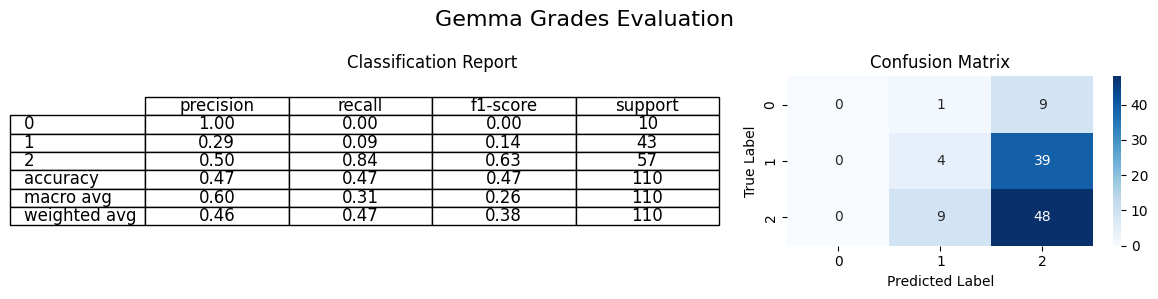

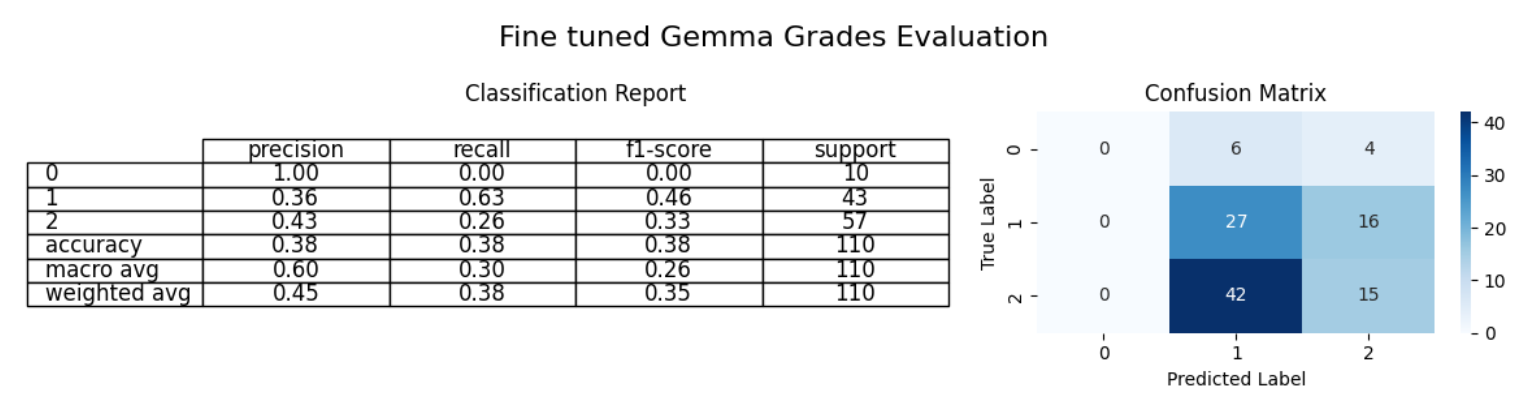

The above metrics were obtained by using few shot and CoT prompting. First of all, here is a quick definition of these metrics :
- Accuracy is the ratio of correctly predicted observations to the total observations.

- Precision for a class is the ratio of true positives for that class to the total instances predicted as that class.

- Recall for a class is the ratio of true positives for that class to what is actually in that class.

- The F1 score measures how effectively our model makes the trade-off between precision and recall.

Gemma shows a better accuracy than its fine tuned version. However, it displays worse F1 score for class 1 than its counterpart, although it displays better F1 score for class 2. Gemma struggles predicting a score of 1 (39 answers were given a 1 although it was actually a 2).

Choosing the second model would mean choosing a better f1-score for class 1 but also a worse f1-score for class 2 **and** a worse accuracy. In our grading system, no score are more important than the other ; therefore, we can afford having a worse f1-score for class 1.

Between Gemma and it's fine-tuned vesion, base Gemma seems to be the best according to the metrics presented here.

#### Feedbacks

In this part, we present the different feedbacks given by the tested models. 5 different questions are represented, with the feedbacks and grades given by the models for the following prompting methods:
- 0-Shot
- 0-Shot with Chain of Thought (CoT)
- Few-shots with Chain of Thought (CoT)

We also look athe the coherence between the grading and feedback given by the models, as a high grade and a negative feedback should not be possible (and vice versa).

##### Gemma Feedbacks

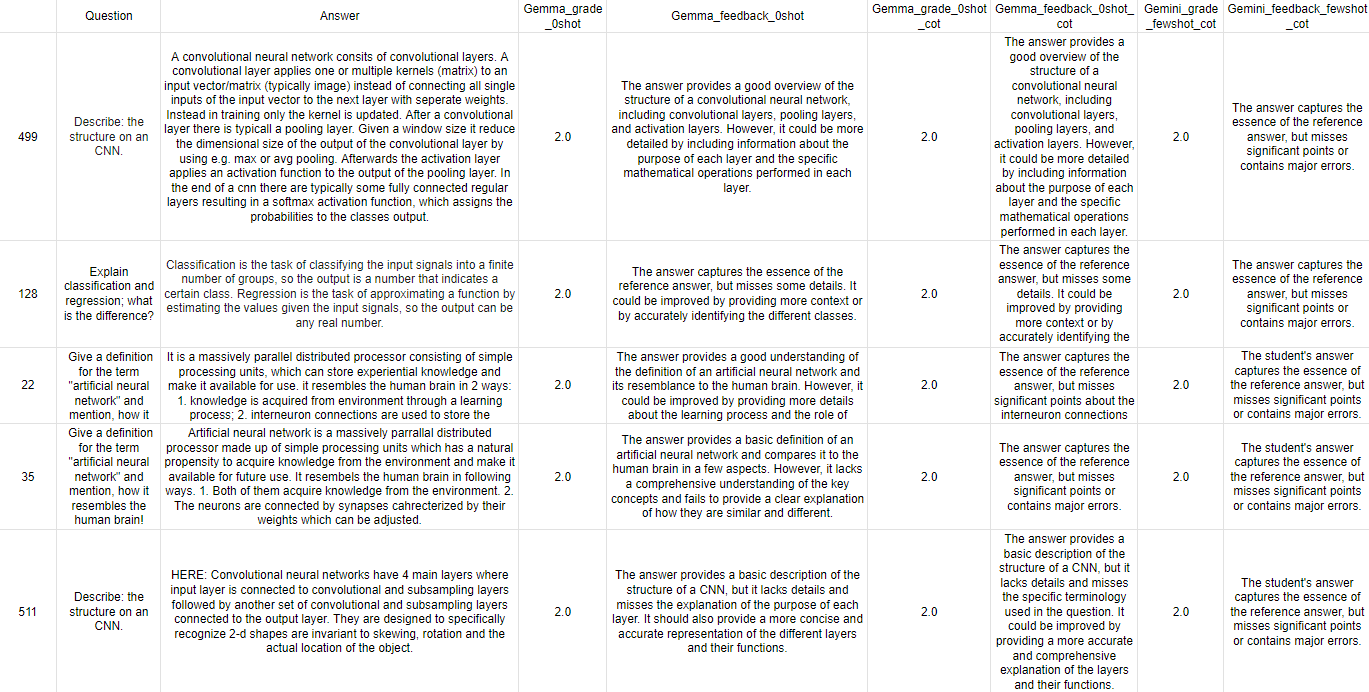

##### Gemma Fine-tuned Feedbacks

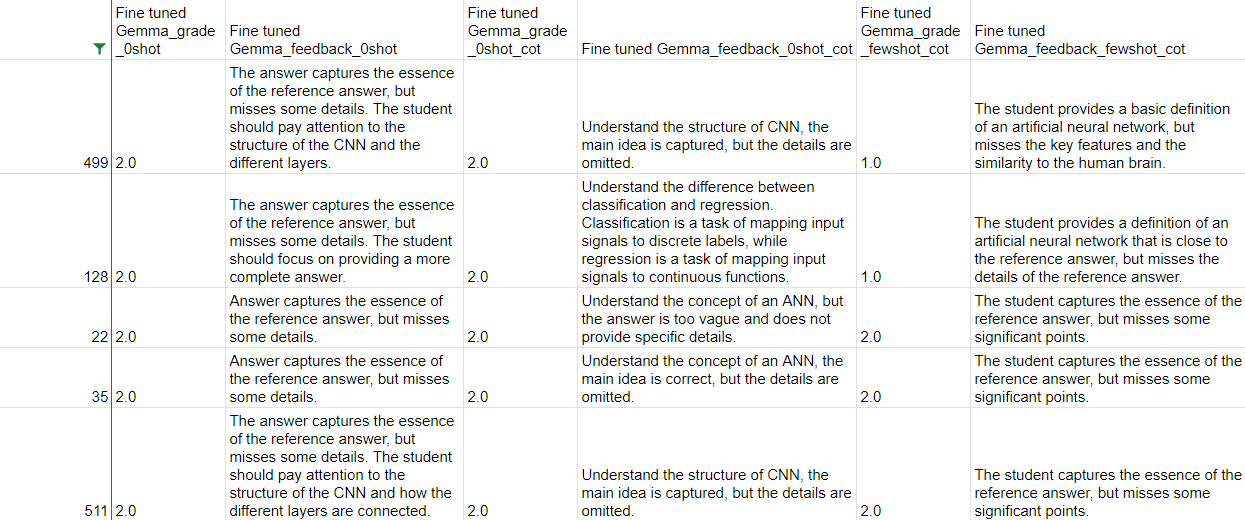

##### Gemini Feedbacks

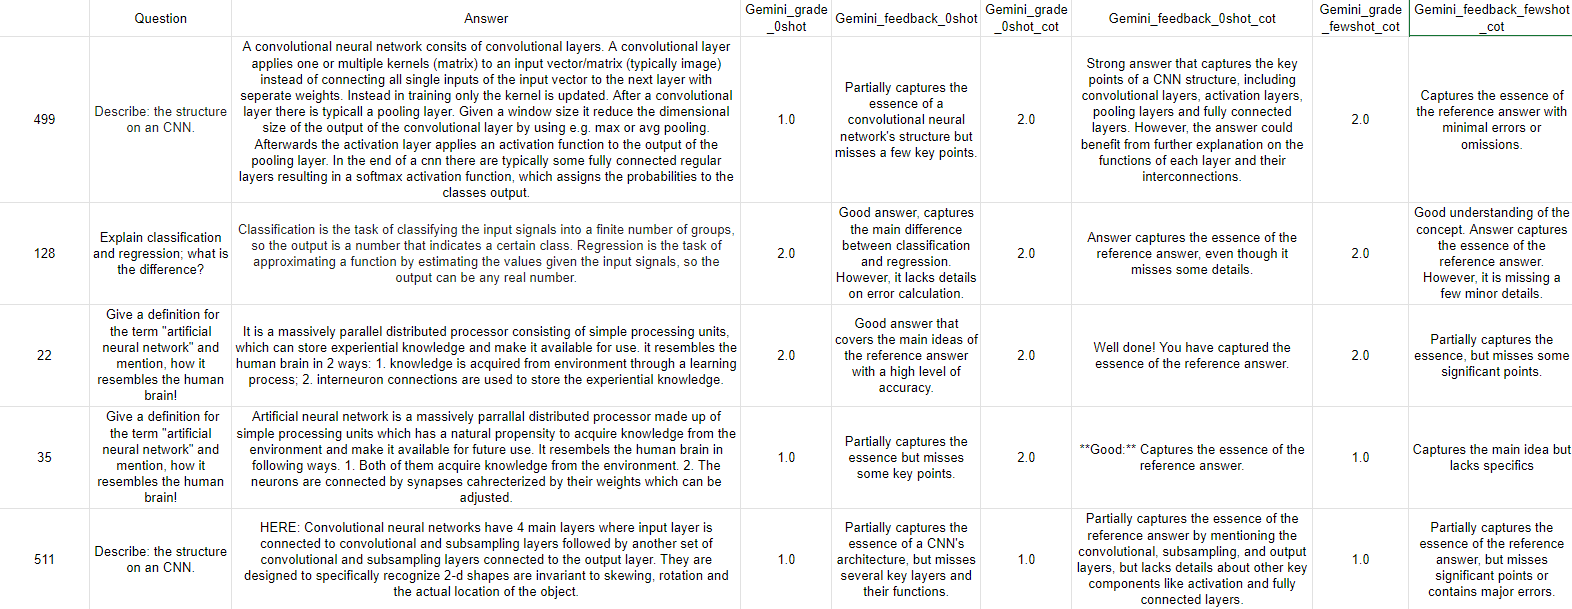

##### A closer look

For the same questions, Gemini and Gemma models present different feedbacks. The prompting techniques used (Zero-shots, Chain-of-thought...) have an influence on the results as well.

The **Gemma** model gives the least coherent results (here in **Few-shots CoT**)




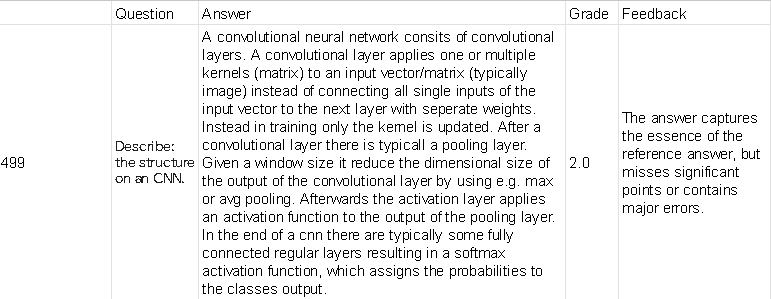

In the image bellow, our Gemma Fine-tuned model gives an answer that is more consistent with the mark it gives (1/2) and her feedback (right but incomplete answer). The feedback has more detail, giving information about a missing part of the student's argument ("[...]similarity with the human brain.").

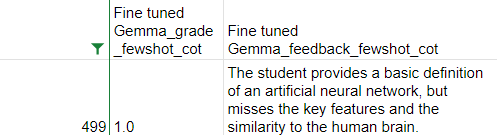


As for **Gemini**, to te previous question "Describe the structure on an CNN", the model returns the following feedback:
> Strong answer that captures the key points of a CNN structure, including convolutional layers, activation layers, pooling layers and fully connected layers. However, the answer could benefit from further explanation on the functions of each layer and their interconnections.

This feedback goes more in depth in its explanation than with Gemma,with details related to the subject of the question. However, it gave a score of 2. Among the feedbacks, some are not consistent with the scores, otherwise the model is still capable of providing coherent feedbacks.

### Improvement

We identified 6 points of improvement in our implementation for this project :

1. The first one  consist on using better prompts. Indeed, we observed in the previous section that they had a strong impact on the model performance.
2. Fine tuning Gemini to compare it with it’s own base model and Gemma fine-tuned. Sadly, this could not be done because of issues with the Google API, which are on the side of Google.
3. Fine tuning models  over several epochs. In this case, fine-tuning could only be done on a single epoch on Gemma, otherwise Google Colab would crash due to a lack of RAM.
4. Answer evaluation by humans. We began this process within the “Comparison > Feedbacks” part. This would have made us able to see erroneous recurring patterns in the models anwser and maybe find a way to correct them.Unfortunately, this couldn't be done as it would take too long reviewing the whole dataset and answers by hand.
5. Change the current models for ones with attention retention mecanisms.
6. Use a balanced dataset : by searching for the distribution of grades in the dataset, we saw a lot of 2/2, some 1/2 and very few 0/2.  A dataset with the same numbers of different classes of grades should yield better results.


## Conclusion



This was an interesting project that was the logical consequence of the applications of LLMs and AI, which serves the purpose of helping and saving time for the teacher during the correction process. However, it would need additionnal work to move towards better and more coherent results.

When comparing classification metrics, Gemma came out as the better model compared to fine tuned Gemma, espcially regarding accuracy.

With regard to feedbacks, Gemma was the least precise and coherent model, showing a lot of inconsistencies with the scores. Fine tuned Gemma was the better model in this regard. The more detailed commentaries came from Gemini, as they were the most coherent with the scores given.

Among the points to improve, we can highlight working on better prompting techniques. We could also improve Gemma's fine tuning and implement fine tuning for Gemini. Finally, other models could be tested, especially current models that use attention retention mecanisms.